## Environment

In [8]:
import numpy as np
import matplotlib.pyplot as plt

from environment import RoadEnvironment
from environment_presets import small_environment_dict

### Define the environment

In [9]:
env = RoadEnvironment(**small_environment_dict)

In [10]:
def rollout(env, policy, verbose=False, plot=False):

    obs = env.reset()
    done = False
    total_reward = 0
    store_rewards = {'reward': [], 
                    'travel_time_reward':[],
                    'maintenance_reward': [],
                    'total_travel_time': []}

    while not done:
        actions = policy(env, obs['edge_observations'])
        # print(state, actions)
        next_obs, reward, done, info = env.step(actions)

        obs = next_obs

        if verbose:
            # print(f"reward: {reward}, travel times: {info}['travel_times], total_travel_time: {info['total_travel_time']}")
            print(f"reward: {reward:.3f}, total_travel_time: {info['total_travel_time']:.3f}")

        total_reward += reward
        store_rewards['reward'].append(reward)
        store_rewards['total_travel_time'].append(info['total_travel_time'])
        store_rewards['travel_time_reward'].append(info['reward_elements'][0])
        store_rewards['maintenance_reward'].append(info['reward_elements'][1])

    if plot:

        fig, ax = plt.subplots(1, 3, figsize=(16, 4))

        # plot total travel time over episode
        ax[0].plot(store_rewards['total_travel_time'])
        ax[0].set_yscale('symlog')
        ax[0].set_xlabel('time_step')
        ax[0].set_title('total travel time')
        ax[0].grid()

        # plot rewards and reward elements over episode
        ax[1].plot(store_rewards['reward'], color='tab:red', label=r'($r_{tt}$ + $r_m$)')
        ax[1].plot(store_rewards['travel_time_reward'], color='tab:blue', alpha=0.5, label=r'travel_time ($r_{tt}$)')
        ax[1].plot(store_rewards['maintenance_reward'], color='tab:green', alpha=0.5, label=r'maintenance ($r_m$)')
        ax[1].tick_params(axis='y', labelcolor='tab:red')
        ax[1].set_title('reward')
        ax[1].set_xlabel('time_step')
        ax[1].grid()
        ax[1].legend()

        # pie chart of the reward elements
        labels = 'travel_time', 'maintenance'
        sizes = [-np.sum(store_rewards['travel_time_reward']), -np.sum(store_rewards['maintenance_reward'])] 
        explode = (0, 0.1)
        ax[2].pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
                shadow=True, startangle=90)
        ax[2].axis('equal')
        ax[2].set_title('reward elements')

    return total_reward

In [11]:
def do_nothing_policy(env, edge_obs): # env forces segments to be replaced when they fail
    return [[0]*segments for segments in env.edge_segments_numbers]

def failure_replace_policy(env, edge_obs):
    action = [[3 if obs == 3 else 0 for obs in e] for e in edge_obs]
    return action

def always_replace_policy(env, edge_obs):
    return [[3]*segments for segments in env.edge_segments_numbers]

-6404.832000000003

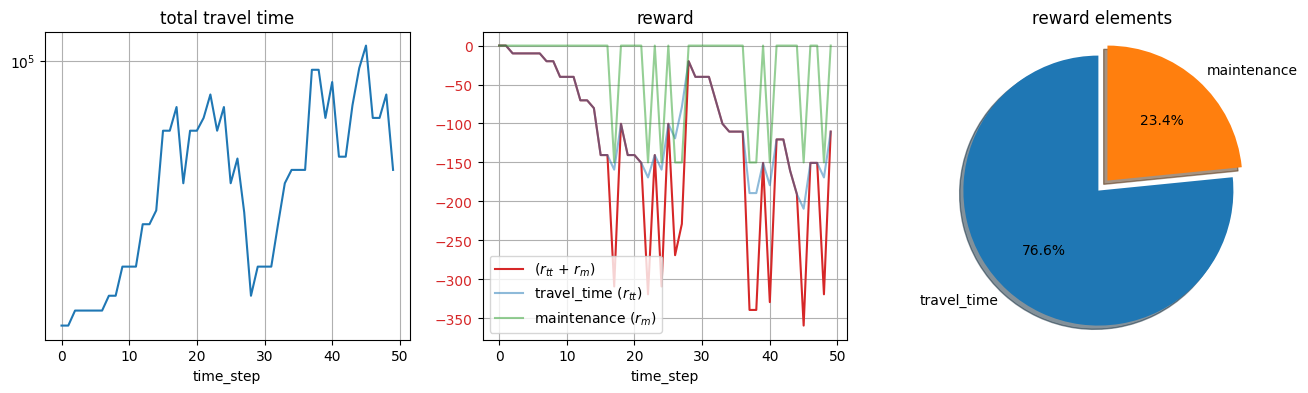

In [12]:
# rollout(env, do_nothing_policy, plot=True)
rollout(env, failure_replace_policy, plot=True)
# rollout(env, always_replace_policy, plot=True)

Baselines: do-nothing, failure-replace, always-replace

In [13]:
NUM_EPISODES = 1_000

store_do_nothing_rewards = np.zeros(NUM_EPISODES)
store_failure_replace_rewards = np.zeros(NUM_EPISODES)
store_always_replace_rewards = np.zeros(NUM_EPISODES)

for episode in range(NUM_EPISODES):

    store_do_nothing_rewards[episode] = rollout(env, do_nothing_policy)
    store_failure_replace_rewards[episode] = rollout(env, failure_replace_policy)
    store_always_replace_rewards[episode] = rollout(env, always_replace_policy)

print(f'Mean reward (do-nothing): {np.mean(store_do_nothing_rewards):.3f}')
print(f'Mean reward (failure replace): {np.mean(store_failure_replace_rewards):.3f}')
print(f'Mean reward (always replace): {np.mean(store_always_replace_rewards):.3f}')

Mean reward (do-nothing): -13876.301
Mean reward (failure replace): -7572.087
Mean reward (always replace): -83532.800


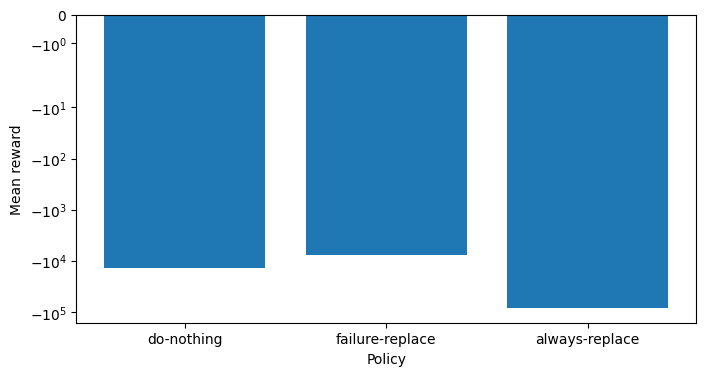

In [24]:
# plot bar chart
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1,1, figsize=(8, 4))
_x = ['do-nothing', 'failure-replace', 'always-replace']
_y = np.array([np.mean(store_do_nothing_rewards), 
                np.mean(store_failure_replace_rewards),
               np.mean(store_always_replace_rewards)])

# add value text on top of each bar
ax.bar(_x, _y)

ax.set_xlabel('Policy')
ax.set_yscale('symlog')
ax.set_ylabel('Mean reward')
plt.show()